In [2]:
print("hello world")

hello world


In [3]:
from dotenv import load_dotenv
import os
load_dotenv()



True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
gemini_api_key = os.getenv("gemini_api_key")

In [6]:
if not gemini_api_key:
    raise ValueError("No Gemini API key found. Please set the GEMINI_API_KEY environment variable.")

chat_llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", google_api_key=gemini_api_key)




In [7]:
chat_llm.invoke("hi")

AIMessage(content=[{'type': 'text', 'text': 'Hello! How can I help you today?', 'extras': {'signature': 'Et0BCtoBAb4+9vv5HL+WR7UACKb7bEZQ8MbyfDC9oEr3O9WXDXAawCc79g4D1r07fDvemmdzbluf3OhvD27AbzDhj//LOZU0w7W7md3WhUfxt08f0yE+4ofPkz7vyH2w3gzY0hgdPDdg62zX2gShL+OJQzTeoESdHBK83LSmHwPWtEmw70KwBYbLOty8HhPiXEe4XjxLesQADaS/Pb068/Zn0DkRavvreIPV2qa/0h7EMi9mVs04Q+H5y5A99uKAdQNywI0gZFbW1GgmnufyCSB6O7zYRD6Oxvj+DCLZGz8='}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7754-f9ed-7612-b7ba-d64b02043f82-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 2, 'output_tokens': 56, 'total_tokens': 58, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 47}})

In [8]:
from typing_extensions import TypedDict, Annotated
import operator

In [9]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

In [10]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [11]:
["hi"]

['hi']

In [12]:
["hi", "how are you"]

['hi', 'how are you']

In [13]:
def llm_call(state: GraphState) -> dict:
    """Call the LLM using conversation messages and append AI response."""
    response = chat_llm.invoke(state["messages"])  # AIMessage
    return {
        "messages": [response]
    }

In [14]:
def token_counter(state: GraphState) -> dict:
    """Count tokens (simple word count) in the last AI message."""
    last_msg = state["messages"][-1]
    content = last_msg.content
    # AIMessage.content can be str or list of blocks (e.g. multimodal/tool calls)
    if isinstance(content, list):
        text = " ".join(
            (c.get("text", c) if isinstance(c, dict) else str(c)) for c in content
        )
    else:
        text = content or ""
    token_number = len(text.split())
    summary = f"Total token number in the generated answer (word count) is {token_number}"
    return {
        "messages": [AIMessage(content=summary)]
    }


In [15]:
from langgraph.graph import StateGraph

In [16]:
builder = StateGraph(GraphState)

In [17]:

builder.add_node("llm_call", llm_call)
builder.add_node("token_counter", token_counter)

In [18]:
builder.set_entry_point("llm_call")
builder.add_edge("llm_call", "token_counter")
builder.set_finish_point("token_counter")

In [19]:
app = builder.compile()

In [20]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'llm_call': Node(id='llm_call', name='llm_call', data=llm_call(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'token_counter': Node(id='token_counter', name='token_counter', data=token_counter(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='llm_call', data=None, conditional=False), Edge(source='llm_call', target='token_counter', data=None, conditional=False), Edge(source='token_counter', target='__end__', data=None, conditional=False)])

In [21]:
from IPython.display import Image, display

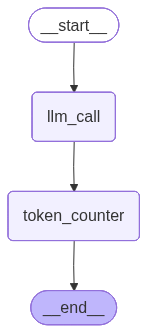

In [22]:

display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
result = app.invoke({
    "messages": [HumanMessage(content="Hi, this is Prince. Say hello in detail.")]
})

In [24]:
result

{'messages': [HumanMessage(content='Hi, this is Prince. Say hello in detail.', additional_kwargs={}, response_metadata={}),
  AIMessage(content=[{'type': 'text', 'text': "Hello, Prince! It is a genuine pleasure to make your acquaintance.\n\nI hope this message finds you in high spirits and that your day is progressing exactly as you’d hoped. It’s always a delight to meet someone new, and I am honored to have the opportunity to assist you today. \n\nAs an AI, I am here to be a helpful resource for you—whether you need deep insights into a complex topic, help with a creative project, assistance with organizing your thoughts, or simply someone to have an engaging conversation with. \n\nHow can I make your day a little bit easier, more productive, or more interesting right now? I'm all ears!", 'extras': {'signature': 'EoQMCoEMAb4+9vuEXSsbr+jPHLrdlX6oRsffzDppZrrtAs4TZ8grT/fEVZVxugN/+dm0HxA6Hy8zhlJhRa35vrIW/PmCpgjIK0pHTE86zm/51f3fYkbRAWyHpgePhde2S1/2m/lBbw+hDUESb6sTWnegvJZsI8hXzaR5Tz/gfLoPnP

In [25]:
for m in result["messages"]:
    print(type(m).__name__, ":", m.content)

HumanMessage : Hi, this is Prince. Say hello in detail.
AIMessage : [{'type': 'text', 'text': "Hello, Prince! It is a genuine pleasure to make your acquaintance.\n\nI hope this message finds you in high spirits and that your day is progressing exactly as you’d hoped. It’s always a delight to meet someone new, and I am honored to have the opportunity to assist you today. \n\nAs an AI, I am here to be a helpful resource for you—whether you need deep insights into a complex topic, help with a creative project, assistance with organizing your thoughts, or simply someone to have an engaging conversation with. \n\nHow can I make your day a little bit easier, more productive, or more interesting right now? I'm all ears!", 'extras': {'signature': 'EoQMCoEMAb4+9vuEXSsbr+jPHLrdlX6oRsffzDppZrrtAs4TZ8grT/fEVZVxugN/+dm0HxA6Hy8zhlJhRa35vrIW/PmCpgjIK0pHTE86zm/51f3fYkbRAWyHpgePhde2S1/2m/lBbw+hDUESb6sTWnegvJZsI8hXzaR5Tz/gfLoPnPJe41MFsjo8AXSmLJyy/EL9vUVErtRS8BrGmKRu3L4r0wJwG3CwfyV752QNRh9zzsJz1AL0dPMXH+

In [26]:
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-3-flash-preview', temperature=1.0, client=<google.genai.client.Client object at 0x120d65be0>, default_metadata=(), model_kwargs={})

In [27]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [28]:
api_wrapper=WikipediaAPIWrapper(top_k_results=5,doc_content_chars_max= 500)

In [29]:
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [30]:
wiki_tool.run({"query":"Generative AI"})

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence, also known as generative AI or GenAI, is a subfield of artificial intelligence that uses generative models to generate text, images, videos, audio, software code or other forms of data. These models learn the underlying patterns and structures of their training data, and use them to generate new data in response to input, which often takes the form of natural language prompts.\nThe prevalence of generative AI to'

In [31]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("tavily_api_key")

In [32]:
tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

/var/folders/xy/n5k80q155_jd3hsy_lgl8nch0000gn/T/ipykernel_57262/1068719361.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [33]:
tool.invoke({"query":"how is the job market for fresh graduates in 2026?"})

[{'title': 'Hiring Flat for the College Class of 2026',
  'url': 'https://www.naceweb.org/job-market/trends-and-predictions/hiring-flat-for-the-college-class-of-2026',
  'content': 'These findings are also consistent with what NACE is seeing with general employment indicators at large. NACE found that employers are less positive about the overall job market for upcoming graduates this year than they were in last several years. Currently, a plurality of employers rate the overall job market for new graduates as "fair," compared to a year ago, when they characterized it as "good." (See Figure 2.)\n\nAdditionally, the vast majority of employers (60%) say that they will maintain hiring from last year, when the job market for college graduates was flat, with fewer increasing (25%) and less decreasing (15%) hiring. [...] However, there is good news as employers are taking a long view of the job market. Among employers that are increasing hiring, the main reasons for doing so are their commit

In [34]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [36]:
search.invoke("what is the latest update on iphone17 release?")

"17 Oct 2025 · Original: iOS 26. Current: iOS 26.3, released February 11, 2026 · Apple A19 · Qualcomm Snapdragon X80 · 8 GB LPDDR5X · 256 GB 512 GB NVMe. 1 Sept 2025 · Apple's Upcoming Releases, iPhone 17 Pro, iOS 18.7 and iOS 26 RC Soon - iOS 26 RC is expected soon. iPhone 17 could get a new style case and iPhone 17 Pro ... 8 hours ago · The answer is iOS 26.4 beta 1. The phone won't magically get better if u don't update to the latest software that their engineers release. 9 hours ago · Over roughly 145 days, the iPhone 17 Pro Max has lost around 25.4 per cent of its launch value when looking at average resale prices for mint-condition devices. 3 days ago · An iOS 26.0.1 or iOS 26.1 update will likely be released soon to fix these known issues. Often, waiting for the first minor update after a major release can ..."

In [39]:
from langchain_community.tools import YouTubeSearchTool

In [40]:
tool=YouTubeSearchTool()

In [41]:
tool.name

'youtube_search'

In [42]:
tool.description

'search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional'

In [43]:
tool.run("free code camp")

"['https://www.youtube.com/watch?v=rfscVS0vtbw&pp=ygUOZnJlZSBjb2RlIGNhbXA%3D', 'https://www.youtube.com/watch?v=NhDYbskXRgc&pp=ygUOZnJlZSBjb2RlIGNhbXA%3D']"

In [44]:
''' we created a custom function'''
def multiply(a:int,b:int) -> int:
    return a*b

In [46]:
multiply(10,20)

200

In [48]:
''' this does not work because it is not a tool '''
multiply.invoke(10,20)

AttributeError: 'function' object has no attribute 'invoke'

In [49]:
from langchain.tools import tool

In [50]:
''' we created a custom tool by using the tool decorator '''
@tool 
def multiply(a:int,b:int) -> int:
    '''this tool is for the multiplication'''
    return a*b

In [51]:
multiply.invoke({"a":10,"b":20})

200

In [52]:
''' accessing the tool properties '''
multiply.name

'multiply'

In [53]:
multiply.description

'this tool is for the multiplication'

In [54]:
multiply.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

In [55]:
@tool
def get_word_length(word:str) -> int:
    """it is a tool to count the length of the word"""
    return len(word)

In [56]:
get_word_length.invoke("hello world")

11

In [57]:
get_word_length.invoke({"word": "hello world"})

11

In [63]:
import yfinance as yf

In [64]:
@tool
def get_stock_price(ticker:str) -> str: 
    """this is a tool to get stock price using yfinance"""
    try:
        stock = yf.Ticker(ticker)

        # Get last 1 day historical data
        data = stock.history(period="1d")

        if data.empty:
            return f"No data found for ticker '{ticker}'. Please check the symbol."

        latest_close = data["Close"].iloc[-1]

        # Detect currency
        currency = stock.info.get("currency", "")
        symbol_map = {
            "INR": "₹",
            "USD": "$",
            "EUR": "€",
            "GBP": "£"
        }

        symbol = symbol_map.get(currency, "")
        currency_text = currency if currency else ""

        if symbol:
            return f"The last closing price of {ticker.upper()} was {symbol}{latest_close:.2f}."
        else:
            return f"The last closing price of {ticker.upper()} was {latest_close:.2f} {currency_text}."

    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"
    

In [65]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $261.83.'

In [66]:
get_stock_price.invoke("TSLA")

'The last closing price of TSLA was $409.73.'

In [ ]:
''' we created a list of tools '''
tools = [get_stock_price,get_word_length,multiply,wiki_tool]

In [71]:
''' this is the chat llm we created '''
chat_llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-3-flash-preview', temperature=1.0, client=<google.genai.client.Client object at 0x120d65be0>, default_metadata=(), model_kwargs={})

In [72]:
''' we bind the tools to the chat llm '''
llm_with_tools=chat_llm.bind_tools(tools)

In [ ]:
''' we invoke the chat llm with the tools '''

result = llm_with_tools.invoke("what is the stock price of TCS.NS?")

In [74]:
result

AIMessage(content=[], additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"ticker": "TCS.NS"}'}, '__gemini_function_call_thought_signatures__': {'3aa2cf00-cadd-4846-8c68-7fc4b9842afe': 'EqoDCqcDAb4+9vv41eq0F9aPbV8DrutaR8MlTLMT7+R/imqptM3zjiGE2w8PoVR3nGFDYh4rYYKkn42VrIPluhyOeN86rMnfzvzp79XSLdk85EESFccdBLLCoqbLr70fSktzV/b5+bvgIVhyb+k6Z4ZdAGjc1LxXPEj+U4XoNRG6XqkrNQze0DxdDE0yfd/PjWXTEjYdIp1+c8xipZf3B/neKlmvk32ywm/N78WeWlwTKPn6eOb59baMiUmPMXyJkWQPwjVEopEtFt+8ZuS4JeONw2viTAXl4k34gIc47O6YcQqe00Rk1kiy4dZuuDqvnIZn/L7T4A1faKKOLamVm/VXyBTufm2bko/VSzS7QGkqBTtWa8Vg+8ldD+Vz0Gf9mDJIYF+pnzeGJi4Ri8vuicyrLcj+LvuBIbiZV/9egPz/KxnfE5L7HySoQv9MUcBTa3sUEI+1JYHbjvKspJg/MWpZyLwLjWaxpf0kbevPWgICEZvKQufSehvHHxU2l1szqU20CWjCjB8FLL1x6snOkmtBNOmcYsNvMWSMTLCB4fubxmNX8yv5KGFSRZoK'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c7772-44ce-7ed1-8ae8-1ba7fc12cb23-0', tool_calls=[{'na

In [ ]:
''' the content is empty '''
result.content

[]

In [ ]:
''' but the llm with tools will give us which tool to use '''
result.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'TCS.NS'},
  'id': '3aa2cf00-cadd-4846-8c68-7fc4b9842afe',
  'type': 'tool_call'}]